# Предсказание оттока и повышение качества работы с клиентами фитнес-центра

## Описание проекта

Сеть фитнес-центров "Культурист-датасаентист" разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных. Стратегия направлена на борьбу с оттоком клиентов (считается, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал). Необходимо провести анализ информации о клиентах и подготовить план действий по их удержанию, а именно:
- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами.

## <a name="0"> Структура проекта </a>

- [Загрузка данных и ознакомление с ними](#1)
- [Анализ данных](#2)
  - [Анализ категориальных признаков](#2.1)
  - [Анализ количественных признаков](#2.2)
  - [Матрица корреляции](#2.3)
- [Прогноз оттока клиентов](#3)
- [Кластеризация клиентов](#4)
  - [Агломеративная иерархическая кластеризация](#4.1)
  - [K-Means](#4.1)
  - [Анализ кластеров клиентов и рекомендации](#4.3)
- [Общие выводы](#5)

## <a name="1"> Загрузка данных и ознакомление с ними </a>

Загрузим необходимые библиотеки для работы с таблицами, визуализации данных и машинного обучения:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
import warnings
warnings.simplefilter('ignore')

Загрузим таблицу с данными и посмотрим на неё:

In [2]:
gym_churn = pd.read_csv('/datasets/gym_churn.csv')
gym_churn.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [3]:
gym_churn.shape

(4000, 14)

В таблице 4000 строк (каждая строка - информация о клиенте) и 14 столбцов (13 признаков клиента и 1 целевая переменная - остался клиент через месяц или ушёл). В столбцах хранится следующая информация:
- 'gender' - пол;
- 'Near_Location' - проживание или работа в районе, где находится фитнес-центр;
- 'Partner' - сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент - в таком случае фитнес-центр хранит информацию о работодателе клиента);
- Promo_friends - факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- 'Phone' - наличие контактного телефона;
- 'Contract_period' - длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год);
- 'Group_visits' - факт посещения групповых занятий;
- 'Age' - возраст;
- 'Avg_additional_charges_total' - суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон;
- 'Month_to_end_contract' - срок до окончания текущего действующего абонемента (в месяцах);
- 'Lifetime' - время с момента первого обращения в фитнес-центр (в месяцах);
- 'Avg_class_frequency_total' - средняя частота посещений в неделю за все время с начала действия абонемента;
- 'Avg_class_frequency_current_month' - средняя частота посещений в неделю за предыдущий месяц;
- 'Churn' - факт оттока.

Посмотрим на типы данных в столбцах и количество пропусков:

In [4]:
gym_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


Данные в столбцах двух типов: float и int. Пропусков в таблице нет. 

Проверим наличие дублей:

In [5]:
gym_churn.duplicated().sum()

0

Дублей также нет.

Посмотрим на статистические характеристики данных:

In [6]:
gym_churn.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
Near_Location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
Partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
Promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
Phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
Contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
Group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
Age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
Avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
Month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


По этой таблице можно сформировать представление о среднестатистическом клиенте наших фитнес-центров:
- ему 29 лет ('Age');
- он живёт или работает поблизости с центром ('Near_Location');
- он оставил свой номер телефона ('Phone');
- он ходит в центр уже 4 месяца ('Lifetime');
- в среднем 2 раза в неделю ('Avg_class_frequency_total');
- потратил на дополнительные услуги 147 ден. ед ('Avg_additional_charges_total');
- его действующий абонемент рассчитан на 5 месяцев ('Contract_period');
- и заканчивается через 4 месяца ('Month_to_end_contract');
- он скорее пришёл не по акции "приведи друга" ('Promo_friends').

Что касается таких признаков, как пол ('gender') и пришёл ли клиент от компании-партнёра ('Partner'), то в центры ходят в равной степени мужчины и женщины, от компаний-партнёров и нет.

Медианный клиент отличается от среднестатистического тем, что:
- его действующий абонемент рассчитан на 1 месяц, а не на 5 ('Contract_period');
- и заканчивается через 1 месяц, а не 4 ('Month_to_end_contract');
- ходит в центр 3, а не 4 месяца ('Lifetime');
- он потратил меньше на дополнительные услуги - 136 ден. ед ('Avg_additional_charges_total').

Также в таблице можно заметить, что часть признаков меняется от 0 до 1 - это категориальные данные. Они закодированы цифрами '0' и '1', где эти цифры скорее всего означают следующее: '1' - признак характерен клиенту, '0' - признак не характерен клиенту. Невозможно установить смысл такой кодировки только для признака 'gender', поэтому условно будем считать, что '1' - это мужской пол, а '0' - женский. Так будет проще и нагляднее делать выводы о взаимосвязи пола с другими признаками и целевой переменной (если, конечно, мы их обнаружим). Целевая переменная также относится к категориальным данным. 

Значения оставшихся признаков колеблются в более широком диапазоне - их можно отнести к количественным данным. Исключение: 'Contract_period' - так как у него всего три значения, то отнесём его также к категорильным признакам:

In [7]:
gym_churn['Contract_period'].unique()

array([ 6, 12,  1])

Для дальнейшего удобства анализа составим список категориальных и количественных признаков:

In [8]:
categorical_features = ['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone'
                       , 'Contract_period', 'Group_visits']
numerical_features = ['Age', 'Avg_additional_charges_total', 'Month_to_end_contract', 'Lifetime'
                      , 'Avg_class_frequency_total', 'Avg_class_frequency_current_month']

Обычно на следующем этапе делают предобработку данных, но нам с ними повезло: дублей нет, пропусков нет, явных выбросов тоже не видно. Поэтому этап предобработки пропускаем и переходим к анализу данных.

[К началу](#0)

## <a name="2"> Анализ данных </a>

### <a name="2.1"> Анализ категориальных признаков </a>

Узнаем, сколько клиентов ушли через месяц, а сколько остались:

In [9]:
gym_churn['Churn'].value_counts()

0    2939
1    1061
Name: Churn, dtype: int64

Примерно четверть клиентов покинула фитнес-центры - довольно большая доля.

Теперь изучим категориальные признаки клиентов и их взаимосвязь с оттоком. Проще всего составить впечатление с помощью визуализации - построим графики распределения клиентов по значениям признаков.

Для построения графиков нам пригодится функция, которая будет строить столбиковую диаграмму:

In [10]:
def barplot(data, x, y, title, xlabel, ylabel, legend, color):
    data.plot(x, y, kind='bar', figsize=(6, 3), alpha=.7, legend=legend, color=color)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel) 
    plt.show()

Также напишем функцию, которая будет выводить:
1. Сводную таблицу с общим количеством клиентов, количеством ушедших клиентов и долей оттока в зависимости от изучаемого признака;
2. Диаграмму с общим количеством клиентов и количеством ушедших клиентов в зависимости от изучаемого признака (так мы сможем визуально оценить распределение всех клиентов и ушедших клиентов);
3. Диаграмму с долей ушедших клиентов в зависимости от изучаемого признака (так мы визуально оценим, как признак влияет на отток).

In [11]:
def analyse_categorical(feature):
    temp = gym_churn.groupby(feature).agg({'Churn': ['count', 'sum']}).reset_index()
    temp.columns = [feature, 'total_clients', 'churn_clients']
    temp['churn_rate'] = round(temp['churn_clients'] / temp['total_clients'], 2)
    print(temp)
    title = f"Общее количество клиентов и количество ушедших клиентов \n в зависимости от признака '{feature}'"
    xlabel = 'Значение признака'
    ylabel = 'Количество клиентов'
    barplot(temp, feature, ['total_clients', 'churn_clients'], title, xlabel, ylabel, True, None)
    title = f"Доля ушедших клиентов в зависимости от признака '{feature}'"
    ylabel = 'Доля ушедших клиентов'
    barplot(temp, feature, 'churn_rate', title, xlabel, ylabel, True, 'tomato')

Воспользуемся функцией. Начнём с признака 'gender' - пол:

   gender  total_clients  churn_clients  churn_rate
0       0           1959            519        0.26
1       1           2041            542        0.27


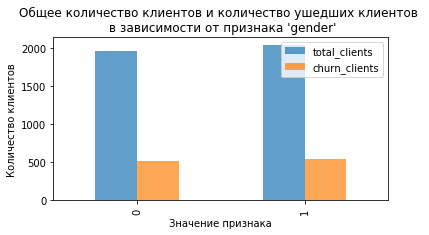

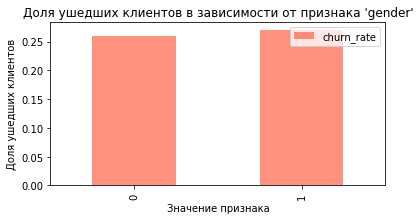

In [12]:
analyse_categorical('gender')

Количество клиентов женского и мужского пола примерно одинаковое. Доли ушедших клиентов среди клиентов разного пола также одинаковые. Это означает, что факт ухода клиента не связан с его полом, то есть признак не влияет на целевую переменную. Поэтому его можно не использовать в будущем при обучении моделей.

Изучим признак 'Near_Location' - проживание или работа в районе, где находится фитнес-центр:

   Near_Location  total_clients  churn_clients  churn_rate
0              0            619            246        0.40
1              1           3381            815        0.24


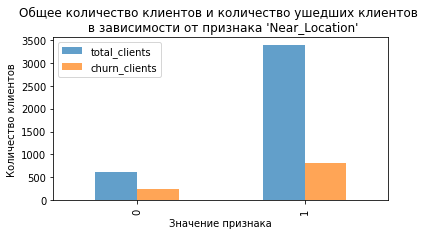

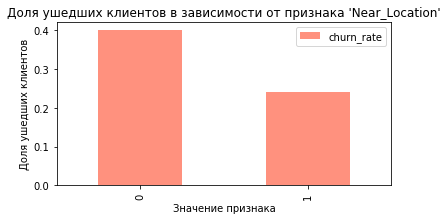

In [13]:
analyse_categorical('Near_Location')

Клиентов, которые проживают или работают в районе, где находится фитнес-центр, примерно в 5 раз больше, чем остальных клиентов. А доля ушедших среди таких клиентов почти в 2 раза меньше. Это означает, что клиенты "поблизости" - это наше ядро и при том это самые надёжные клиенты. Привлекать стоит именно таких клиентов.

Изучим признак 'Partner' - сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент - в таком случае фитнес-центр хранит информацию о работодателе клиента):

   Partner  total_clients  churn_clients  churn_rate
0        0           2053            684        0.33
1        1           1947            377        0.19


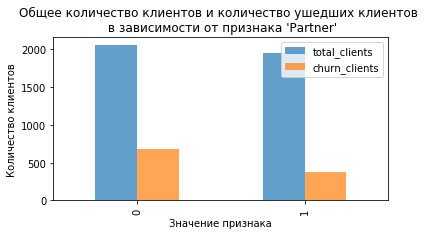

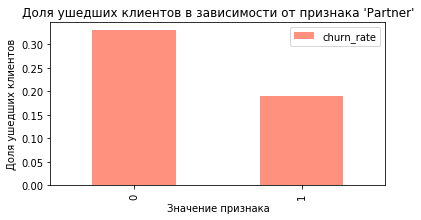

In [14]:
analyse_categorical('Partner')

Клиентов, которые пришли от компаний-партнёров, и остальных клиентов примерно поровну. А вот доли ушедших отличаются: у клиентов от партнёров она значительно ниже. Надо больше привлекать таких клиентов, активнее работать с партнёрами, расширять их сеть.

Изучим признак 'Promo_friends' - факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента):

   Promo_friends  total_clients  churn_clients  churn_rate
0              0           2766            866        0.31
1              1           1234            195        0.16


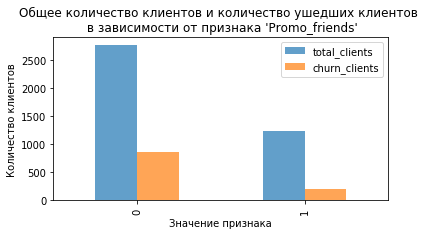

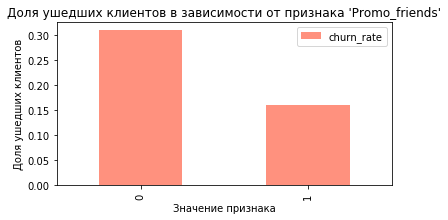

In [15]:
analyse_categorical('Promo_friends')

Примерно треть клиентов пришла в рамках акции «приведи друга». Доля ушедших среди таких клиентов в 2 раза ниже, чем доля ушедших среди остальных клиентов. Акция работает: мы собрали не просто клиентов, но ещё и лояльных.

Изучим признак 'Phone' - наличие контактного телефона:

   Phone  total_clients  churn_clients  churn_rate
0      0            386            103        0.27
1      1           3614            958        0.27


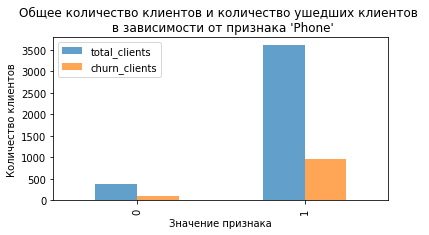

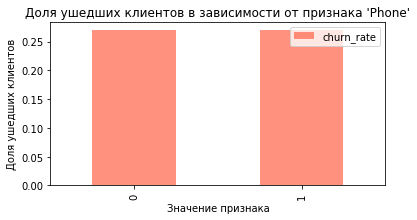

In [16]:
analyse_categorical('Phone')

Клиентов, чьи телефоны у нас есть, почти в 10 раз больше, чем остальных. Однако этот признак не влияет на факт ухода клиента. Поэтому его можно не использовать при обучении моделей. 

Изучим признак 'Contract_period' - длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год):

   Contract_period  total_clients  churn_clients  churn_rate
0                1           2207            934        0.42
1                6            833            104        0.12
2               12            960             23        0.02


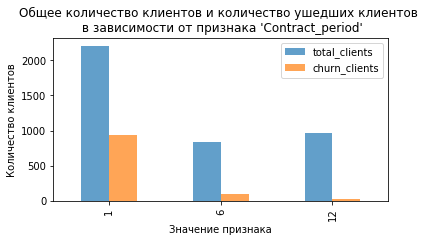

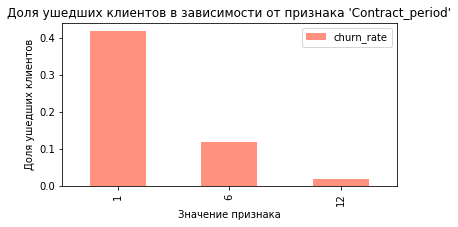

In [17]:
analyse_categorical('Contract_period')

У более половины клиентов короткие абонементы, которые рассчитаны всего на 1 месяц. При этом доля ушедших среди таких клиентов наибольшая и составляет 42%. А вот среди клиентов, у которых абонемент оплачен на 12 месяцев, оттока почти нет. Эти клиенты знают, чего хотят, и так просто фитнес-центр не покидают. Либо им просто приходится ходить, так как уже всё оплачено, и это их удерживает. Нужно стимулировать продажу "долгосрочных" абонементов. 

Изучим признак 'Group_visits' - факт посещения групповых занятий:

   Group_visits  total_clients  churn_clients  churn_rate
0             0           2351            776        0.33
1             1           1649            285        0.17


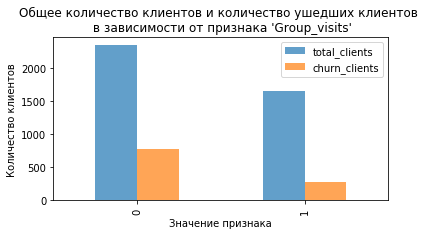

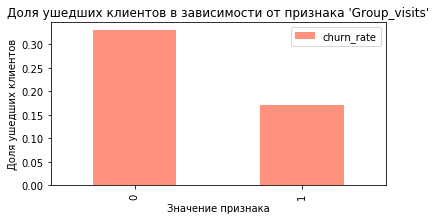

In [18]:
analyse_categorical('Group_visits')

Клиентов, которые посетили групповые занятия, немного меньше, чем остальных. А доля оттока среди таких клиентов ниже примерно в два раза. Либо групповые занятия делают клиентов более лояльными, либо лояльные клиенты ходят на групповые занятия. Если верно первое, то нужно клиентов, которые еще не посещали групповые занятия, активно приглашать их посетить.

### <a name="2.2"> Анализ количественных признаков </a>

Теперь изучим количественные признаки. Их распределение оценивают с помощью гистограмм и диаграмм размахов, поэтому напишем функции, которые их будут строить:

In [19]:
def histplot(feature, title, xlabel, ylabel, bins):
    plt.figure(figsize=(7, 3))
    plt.hist(gym_churn[feature], bins, label='total_clients')
    plt.hist(gym_churn.query('Churn == 1')[feature], bins, label='churn_clients')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel) 
    plt.legend()
    plt.show()

In [20]:
def boxplot(feature, title, ylabel):
    plt.figure(figsize=(7, 3))
    plt.boxplot([gym_churn[feature], gym_churn.query('Churn == 1')[feature]])
    plt.title(title)
    plt.ylabel(ylabel) 
    plt.xticks([1, 2], ['total_clients', 'churn_clients'])
    plt.show()

Также напишем функцию, которая будет выводить:
1. Гистограмму распределения всех клиентов и ушедших клиентов в зависимости от значения признака (так мы сможем увидеть, смещена ли гистограмма ушедших клиенты относительно гистограммы всех клиентов, то есть существует ли влияние признака на целевую переменную);
2. Диаграмму размаха для всех клиентов и ушедших клиентов в зависимости от значения признака (увидим, насколько "ящики с усами" смещены друг относительно друга, то есть оценим влияние признака на целевую переменную немного под другим углом);
3. Средние и медианы признака для всех клиентов и ушедших клиентов (сравним их).

In [21]:
def analyse_numerical(feature, bins):
    title = f"Распределение всех клиентов и ушедших клиентов \n в зависимости от признака '{feature}'"
    xlabel = 'Значение признака'
    ylabel = 'Количество клиентов'
    histplot(feature=feature, title=title, xlabel=xlabel, ylabel=ylabel, bins=bins)
    boxplot(feature, title, ylabel=xlabel)
    print(f'Среднее и медиана признака для всех клиентов: {round(gym_churn[feature].mean(), 1)},\
{round(gym_churn[feature].median(), 1)}')
    print(f'Среднее и медиана признака для ушедших клиентов: {round(gym_churn.query("Churn == 1")[feature].mean(), 1)},\
{round(gym_churn.query("Churn == 1")[feature].median(), 1)}')

Изучим признак 'Age' - возраст:

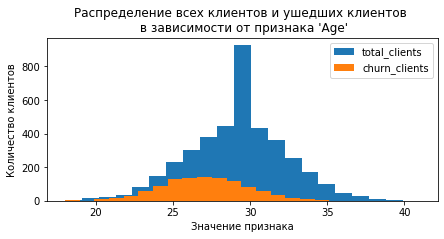

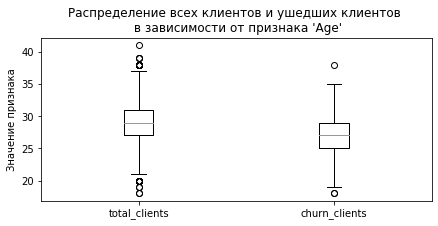

Среднее и медиана признака для всех клиентов: 29.2,29.0
Среднее и медиана признака для ушедших клиентов: 27.0,27.0


In [22]:
analyse_numerical('Age', 21)

Гистограмма ушедших клиентов немного смещена в сторону более молодой аудитории. Аналогично смещён ящик ушедших клиентов. Возрастные клиенты, кому за 35 лет, почти не уходят. Возможно имеет смысл привлекать больше клиентов старшего возраста.

Изучим признак 'Avg_additional_charges_total' - суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон:

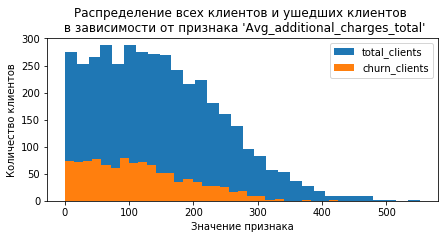

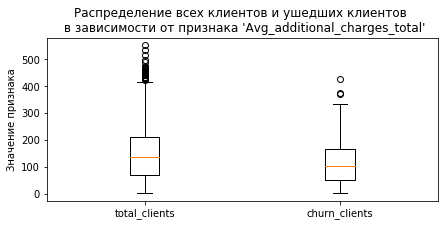

Среднее и медиана признака для всех клиентов: 146.9,136.2
Среднее и медиана признака для ушедших клиентов: 115.1,103.8


In [23]:
analyse_numerical('Avg_additional_charges_total', 30)

Формы обеих гистограмм похожи. Ящики также похожи. Однако видно, что ушедшие клиенты в среднем меньше тратили на дополнительные услуги. А много тратящие клиенты (более 400) не уходят от нас.

Изучим признак 'Month_to_end_contract' - срок до окончания текущего действующего абонемента (в месяцах):

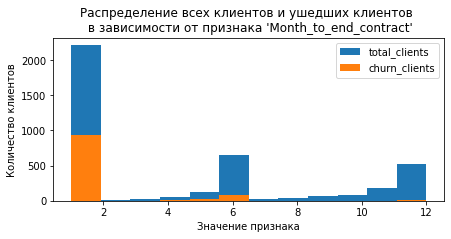

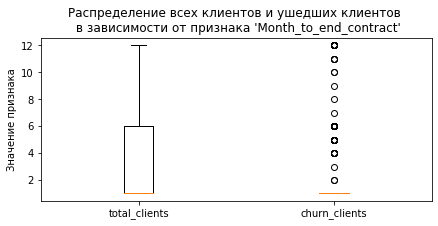

Среднее и медиана признака для всех клиентов: 4.3,1.0
Среднее и медиана признака для ушедших клиентов: 1.7,1.0


In [24]:
analyse_numerical('Month_to_end_contract', 12)

Больше, чем у половины клиентов абонемент заканчивается через месяц. При этом отток среди таких клиентов оказался очень высоким. Надо не допускать истечения срока абонементов клиентов и заранее предлагать им продлить его, например, со скидкой.

Изучим признак 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах):

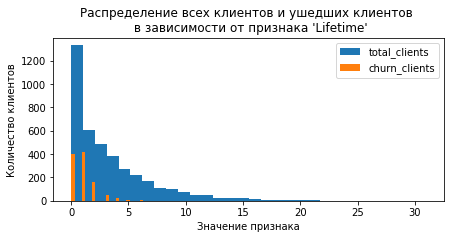

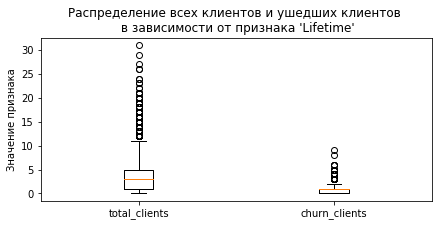

Среднее и медиана признака для всех клиентов: 3.7,3.0
Среднее и медиана признака для ушедших клиентов: 1.0,1.0


In [25]:
analyse_numerical('Lifetime', 30)

Среди клиентов, которые пришли к нам больше 10 месяцев назад, нет оттока. Приятно, что среди "долгожителей" нет ни одного отвалившегося. Также можно заметить, что если клиент ходит в зал больше месяца, вероятность его ухода резко снижается (третий оранжевый столбик на гистограмме). Поэтому особенно важно удерживать клиента в первый месяц. 

Изучим признак 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента:

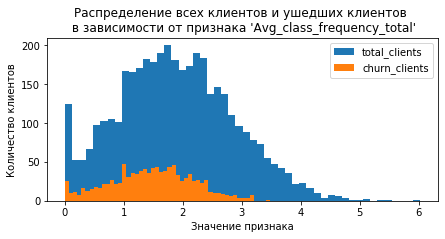

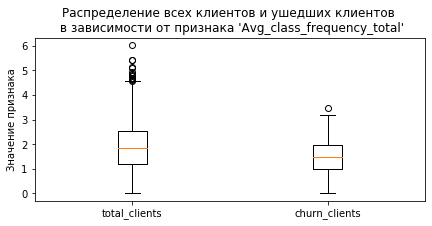

Среднее и медиана признака для всех клиентов: 1.9,1.8
Среднее и медиана признака для ушедших клиентов: 1.5,1.5


In [26]:
analyse_numerical('Avg_class_frequency_total', 50)

Клиенты, которые ушли, ходили в среднем немного реже, чем те, кто остался с нами. Если клиент ходит 4 и более раз в неделю в зал, то он скорее всего не отвалится. 

Изучим признак 'Avg_class_frequency_current_month' - средняя частота посещений в неделю за предыдущий месяц:

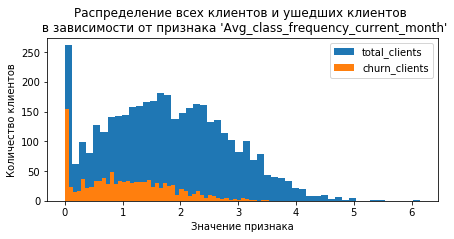

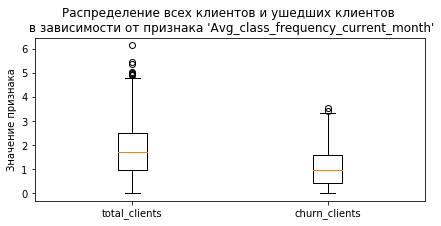

Среднее и медиана признака для всех клиентов: 1.8,1.7
Среднее и медиана признака для ушедших клиентов: 1.0,1.0


In [27]:
analyse_numerical('Avg_class_frequency_current_month', 50)

Если клиенты, которые ушли, в среднем ходили 1,5 раза в неделю за всё время с начала действи абонемента, то в последний месяц они ходили всего 1 раз в неделю. Если клиент начинает реже ходить, то это сигнал, что он может уйти в отток. Возможно стоит предложить ему скидку или бесплатное групповое занятие.

### <a name="2.3"> Матрица корреляции </a>

Оценим линейную взаимосвязь между всеми признаками и целевой переменной попарно - посчитаем коэффициенты корреляции и построим тепловую карту: 

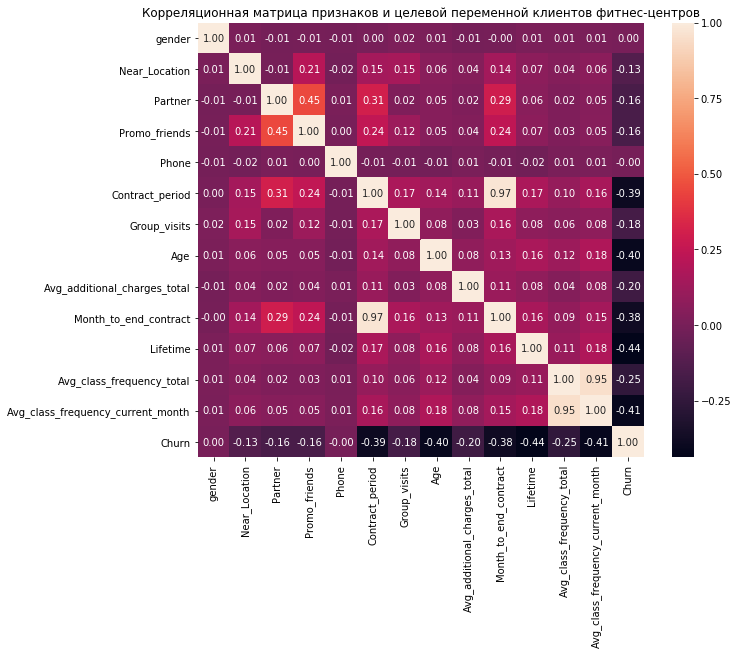

In [28]:
plt.figure(figsize=(10, 8))
plt.title('Корреляционная матрица признаков и целевой переменной клиентов фитнес-центров')
sns.heatmap(gym_churn.corr(), annot = True, fmt='.2f')
plt.show()

Можно заметить, что:
- у признаков 'gender' и 'Phone' нет не только взаимосвязи с целевой переменной, но и с другими признаками;
- на целевую переменную оказывают умеренное влияние 'Age', 'Contract_period', 'Lifetime' и 'Avg_class_frequency_current_month'. Чем больше возраст, срок действия абонемента, время с момента первого посещения и среднее количество посещений в последний месяц, тем ниже отток;
- остальные признаки практически не влияют на целевую переменную;
- есть сильная взаимосвязь между признаками 'Contract_period' и 'Month_to_end_contract' (0,97). Неудивительно - не может быть абонементов, рассчитанных на 1 месяц, со сроком до завершения, скажем, 6 месяцев;
- похожая линейная (0,95) и смысловая взаимосвязь есть между параметрами 'Avg_class_frequency_total' и 'Avg_class_frequency_current_month'.

Как мы выяснили, признаки 'gender' и 'Phone' не несут смысла при обучении моделей. Удалим их:

In [29]:
gym_churn_filtered = gym_churn.drop(['gender', 'Phone'], axis=1)
categorical_features.remove('gender')
categorical_features.remove('Phone')

Пары признаков 'Contract_period' и 'Month_to_end_contract', 'Avg_class_frequency_total' и 'Avg_class_frequency_current_month' коррелируют между собой более, чем на 0,8. Наличие такой линейной взаимосвязи между признаками называют мультиколлинеарностью. Она может привести к переобучению модели, поэтому от неё пытаются избавиться - оставить только один из пары коррелирующих признаков. 

Однако при обучении мы будем использовать алгоритмы, которые имеют встроенную регуляризацию (LogisticRegression) либо не чувствительны к мультиколлинеарности (RandomForestClassifier). Поэтому специально избавляться от сильно скоррелированных признаков не нужно. Возможно модель при обучении вытащит из них дополнительный смысл и лучше обучится (прим. - действительно, эмпирически проверено, что если удалить признаки 'Month_to_end_contract' и 'Avg_class_frequency_total', то модель показывает результаты немного хуже).

[К началу](#0)

## <a name="3"> Прогноз оттока клиентов </a>

Прогноз оттока клиентов является задачей бинарной классификации - на основании признаков клиента мы будем относить его либо к тем, кто уйдёт из фитнес-центра через месяц, либо к тем, кто останется. Для решения этой задачи построим две модели - одну на основании алгоритма логистической регрессии (LogisticRegression), вторую - на алгоритме случайного леса (RandomForestClassifier). Затем сравним, какая модель справляется лучше с задачей.

Для сравнения качества прогноза моделей будем использовать четыре метрики: 

1. Матрицу ошибок, которая отобразит количество верных прогнозов '0' ('TN') и '1' ('TP'), и количество неверных прогнозов '0' ('FN') и '1' ('FP'). По матрице ошибок мы сможем оценить, есть ли у алгоритма перекос в сторону позитивного или негативного значения целевой перменной;


2. Accuracy - долю правильных ответов, которая вычисляется по формуле: 

$$ Accuracy = \frac{TP + TN}{TP + TN + FP + FN} $$ 


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Эта метрика лучше всего работает для сбалансированных классов. У нас же ушедших клиентов примерно в 3 раза меньше, чем &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;оставшихся. Чтобы оценить модели без привязки к соотношению классов, мы рассчитаем также метрики из п. 3 и 4.

3. Precision - доля правильных ответов среди прогнозов значений '1' ('P'). Рассчитывается по формуле:

$$ Precision = \frac{TP}{TP + FP} $$ 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Эта метрика важна, когда в бизнесе факт отнесения к классу "1" стоит ресурсов. В нашем случае это метрика характеризует риск &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;дать скидку или специальное предложение тому клиенту, который не собирался уходить от нас.

4. Recall - доля правильно выявленных значений '1' ('P'). Рассчитывается по формуле:

$$ Recall = \frac{TP}{TP + FN} $$ 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Эта метрика нацелена на минимизацию противоположных рисков - избежать того, что мы не выявим клиента, который уйдёт от нас &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;через месяц. Для бизнеса фитнес-центра это, пожалуй, ключевая метрика: важно не терять клиентов, потому что именно они формируют &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;выручку и окупаются обычно только на продолжительном периоде времени. Поэтому будем делать вывод о лучшей модели именно по &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;этой метрике. 

Перейдём к рассчётам. Для начала разделим данные в таблице gym_churn_filtered на признаки (X) и целевую переменную (y):

In [30]:
X = gym_churn_filtered.drop('Churn', axis=1)
y = gym_churn_filtered['Churn']

Теперь разобьём данные на обучающую и валидационную выборку в соотношении 80/20%:

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y) 

Для обучения модели LogisticRegression необходимо масштабировать признаки: привести их к стандартному виду (со средним 0 и стандартным отклонением 1). Для стандартизации признаков воспользуемся моделью StandardScaler, обучим её на обучающей выборке признаков, а затем масштабируем значения признаков в обучающей и валидационной выборке: 

In [32]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

Напишем функцию, которая на входе будет принимать алгоритм модели для обучения, затем обучать модель на тестовых стандартизированных данных и тестовых целевых переменных, потом делать прогноз для валидационных стандартизированных данных, а на выходе возвращать матрицу ошибок модели и метрики accuracy, precision и recall:

In [33]:
def confusion_matrix(model, model_name):
    model.fit(X_train_st, y_train)
    y_pred = model.predict(X_test_st)
    cm = metrics.confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 4))
    sns.heatmap(cm, annot = True, fmt='.0f')
    plt.title(f'Матрица ошибок модели {model_name}')
    plt.xlabel('Прогноз модели')
    plt.ylabel('Истинное значение')
    plt.show()
    print('Accuracy:', round(metrics.accuracy_score(y_test, y_pred), 3))
    print('Precision:', round(metrics.precision_score(y_test, y_pred), 3))
    print('Recall:', round(metrics.recall_score(y_test, y_pred), 3))

Воспользуемся функцией, обучим и протестируем модель LogisticRegression:

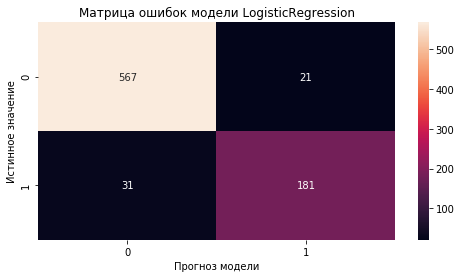

Accuracy: 0.935
Precision: 0.896
Recall: 0.854


In [34]:
confusion_matrix(LogisticRegression(random_state=0), 'LogisticRegression')

Модель логистической регрессии верно определила 567 оставшихся клиента и 181 ушедшего клиента, но ошиблась для 21 клиента, которые остались, и 31 клиента, которые ушли.

Аналогично обучим и протестируем RandomForestClassifier:

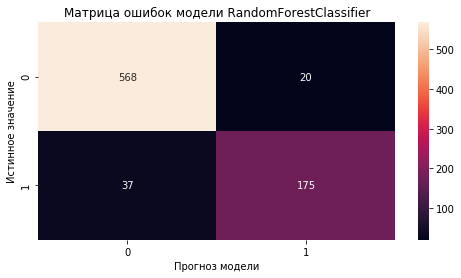

Accuracy: 0.929
Precision: 0.897
Recall: 0.825


In [35]:
confusion_matrix(RandomForestClassifier(n_estimators = 100, random_state=0), 'RandomForestClassifier')

Модель случайного леса верно определила 568 оставшихся клиента и 175 ушедших клиента, но ошиблась для 20 клиентов, которые остались, и 37 клиентов, которые ушли. 

Recall оказался выше у модели LogisticRegression. Так как эту метрику мы определили как главную, то в будущем для прогноза оттока клиентов будем использовать её. 

А вот Precision оказался немного выше у RandomForestClassifier. Применяя модель LogisticRegression месяц назад, мы могли бы неправильно дать на одну скидку или специальное предложение больше, чем если бы применяли RandomForestClassifier. Но это не так критично, как потерять клиента.

[К началу](#0)

## <a name="4"> Кластеризация клиентов </a>

Ещё одна задача, которую необходимо решить - выделить несколько наиболее ярких групп клиентов, определить их особенности и оптимизировать маркетинговые активности. Такая задача называется кластеризацией и решают её с помощью алгоритмов, наиболее популярные среди которых:
- Агломеративная иерархическая кластеризация (не требует заранее заданного числа групп (кластеров));
- K-Means (требует заранее заданное число кластеров).

Воспользумеся обоими алгоритмами. 

### <a name="4.1"> Агломеративная иерархическая кластеризация </a>

Начнём с агломеративной иерархической кластеризации - пусть модель сама предложит количество кластеров и разделим по ним клиентов.

Импортируем модель класса linkage() и передадим ей все стандартизированные признаки клиентов, затем визуализируем получившиеся связи между клиентами в виде дендрограммы:

In [36]:
X_st = scaler.fit_transform(X) # обучаем модель на всех 100% признаках и сразу масштабируем признаки
linked = linkage(X_st, method = 'ward') 

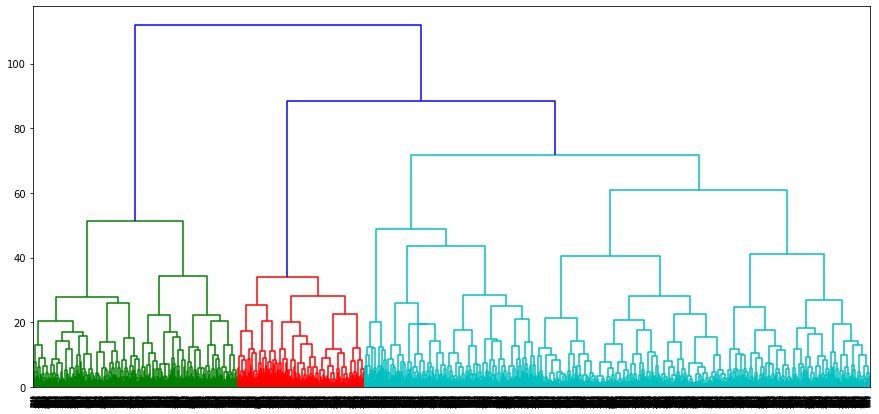

In [37]:
plt.figure(figsize=(15, 7))  
dendrogram(linked, orientation='top')
plt.show() 

Предложенное оптимальное число кластеров 3 — по числу цветов на графике. В основании дендрограммы находятся все 4000 клиентов. Если двигаться по этому графику снизу (от клиентов) вверх, то клиенты будут объединяться сначала с другими наиболее похожими клиентами по парам или небольшим группам, затем группы будут объединяться между собой, пока не превратятся в одну, охватывающую всю выборку клиентов. 

По получившейся дендрограмме можно визуально оценить, сколько кластеров должно быть. Модель предложила 3 кластера, но также, как видно, можно разбить клиентов и на 5 кластеров. Как раз на такое количество кластеров разобьём клиентов алгоритмом K-Means.

### <a name="4.2"> K-Means </a>

Воспользуемся алгоритмом K-Means и разделим клиентов на заранее определённое число кластеров - 5. Создадим модель и применим её к стандартизированным признакам:

In [38]:
km = KMeans(n_clusters = 5, random_state=0)
labels = km.fit_predict(X_st)

Проверим количество кластеров и их названия:

In [39]:
set(labels)

{0, 1, 2, 3, 4}

Добавим значения кластеров в таблицу gym_churn_filtered в столбец 'label':

In [40]:
gym_churn_filtered['label'] = labels

In [41]:
gym_churn_filtered.head()

,Near_Location,Partner,Promo_friends,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn,label
0,1,1,1,6,1,29,14.227470,5.0,3,0.020398,0.000000,0,1
1,1,0,0,12,1,31,113.202938,12.0,7,1.922936,1.910244,0,2
2,1,1,0,1,0,28,129.448479,1.0,2,1.859098,1.736502,0,0
3,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0,2
4,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0,1


Теперь у каждого клиента появился дополнительный признак - номер кластера, к которому он относится.

### <a name="4.3"> Анализ кластеров клиентов и рекомендации </a>

Проведём анализ кластеров, сформированных алгоритмом K-Means. Попробуем выделить особенности клиентов в кластерах, понять, по какому принципу алгоритм поделил клиентов, и выработать рекомендации по работе с клиентами из каждого кластера. 

Сгруппируем клиентов по кластерам и выведем средние значения признаков:

In [42]:
gym_churn_grouped = gym_churn_filtered.groupby('label').mean().reset_index()
gym_churn_grouped

,label,Near_Location,Partner,Promo_friends,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,0,1.000000,0.242667,0.017778,1.960889,0.328000,28.193778,130.930115,1.878222,2.397333,1.293625,1.053260,0.525333
1,1,0.998459,0.812018,1.000000,3.115562,0.454545,29.201849,141.185440,2.893683,3.668721,1.736509,1.631155,0.248074
2,2,0.945279,0.742489,0.490343,11.896996,0.553648,29.915236,164.601148,10.886266,4.701717,1.994642,1.986228,0.022532
3,3,0.000000,0.467772,0.077348,2.232044,0.215470,28.475138,133.715813,2.095764,2.780847,1.649536,1.458297,0.451197
4,4,0.968043,0.267643,0.087883,2.925433,0.468708,30.258322,163.559554,2.684421,5.231691,2.901535,2.904995,0.057257


Оценивать разницу признаков в кластерах удобнее визуально. Напишем функцию, которая будет строить столбиковую диаграмму из средних значений признака в зависимости от кластера (это функция проще написанной ранее функции построения барплота, она требует всего один параметр - признак):

In [43]:
def cluster_barplot(feature):
    gym_churn_grouped.plot(x='label', y=feature, kind='bar', figsize=(8, 3), alpha=.7, legend=True)
    plt.title(f"Среднее значение признака '{feature}' в кластерах")
    plt.xlabel('Кластер')
    plt.ylabel('Значение признака') 
    plt.show()

Воспользуемся функцией и сначала оценим, выявил ли алгоритм K-Means кластеры, клиенты в которых уходят, и кластеры, в которых остаются:

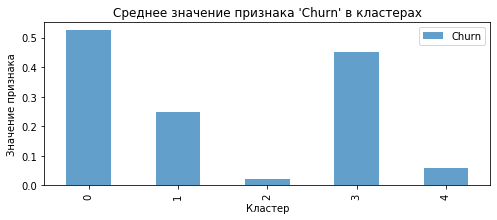

In [44]:
cluster_barplot('Churn')

Не имея доступа к значениям целевой переменной, алгоритм K-Means смог выделить кластеры '2' и '4', в которых клиенты почти не уходят от нас. А с клиентами в других кластерах ('0', '1' и '3') нам нужно лучше работать.

Изучим распределение категориальных признаков по кластерам:

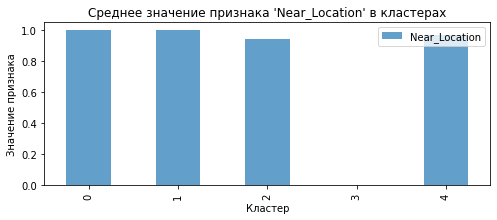

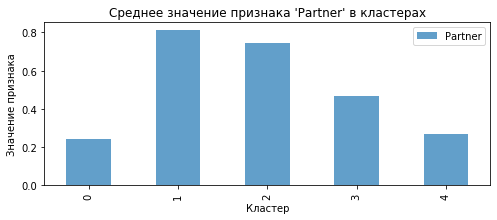

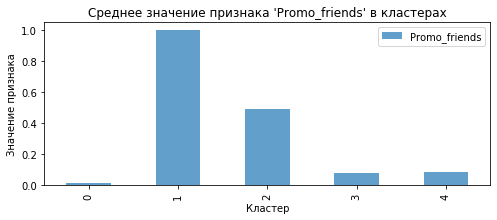

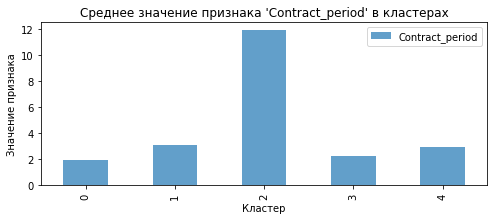

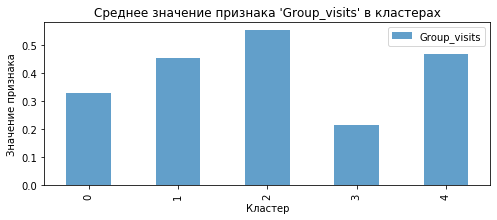

In [45]:
for feature in categorical_features:
    cluster_barplot(feature)

Теперь изучим распределение количественных признаков по кластерам. Также напишем специальную функцию построения диаграмм размаха, котора принимает на вход признак и возвращает его распределение по кластерам: 

In [46]:
def cluster_boxplot(feature):
    plt.figure(figsize=(8, 3))
    plt.boxplot([gym_churn_filtered.query('label == 0')[feature], gym_churn_filtered.query('label == 1')[feature]
            , gym_churn_filtered.query('label == 2')[feature], gym_churn_filtered.query('label == 3')[feature]
            , gym_churn_filtered.query('label == 4')[feature]])
    plt.title(f"Распределение клиентов в кластерах в зависимости \n от признака '{feature}'")
    plt.xlabel('Кластер')
    plt.ylabel('Значение признака') 
    plt.xticks([1, 2, 3, 4, 5], [0, 1, 2, 3, 4])
    plt.show()

Воспользуемся функцией:

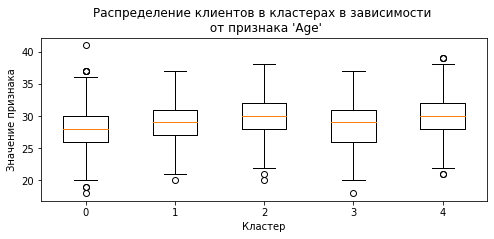

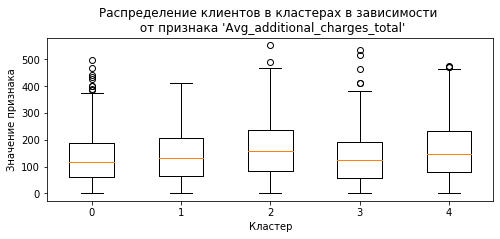

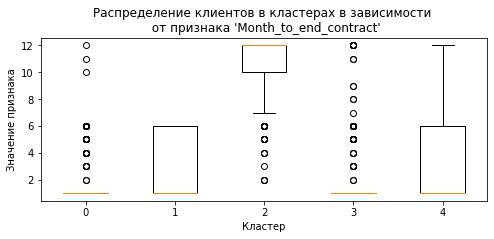

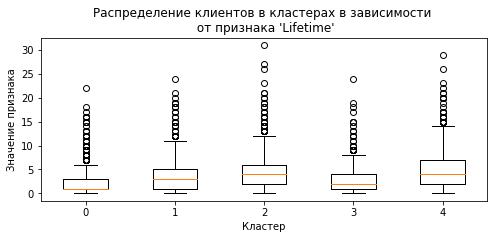

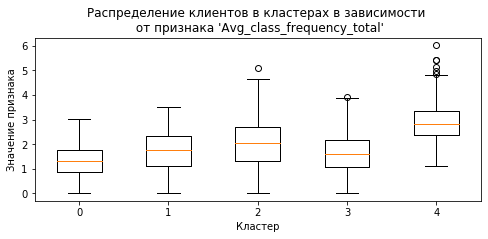

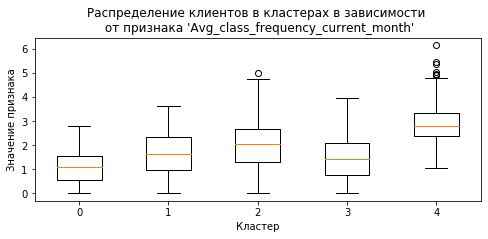

In [47]:
for feature in numerical_features:
    cluster_boxplot(feature)

После изучения графиков можно выделить такие особенности клиентов в кластере '0':
- "плохой" кластер - примерно 50% клиентов уйдут через месяц;
- клиенты живут или работают поблизости с фитнес-центром;
- низкая доля (около 20%) клиентов, которые пришли от компаний-партнёров;
- почти никто из них не пришёл через друзей и знакомых;
- короткие абонементы - в среднем на 2 месяца;
- абонементы заканчиваются через месяц;
- очень редко ходят в зал - половина даже реже 1 раза в неделю.

Главная проблема - низкая активность и "короткие" абонементы, многие из которых заканчиваются уже через месяц, а также то, что эти клиенты пришли не через друзей и не от компаний-партнёров (нет изначальной лояльности). Это случайно забредшие малоактивные клиенты. Чтобы их удержать, мотивировать на тренировки и развить лояльность, можно предложить комплиментарную акцию "каждую вторую тренировку в неделю бесплатный протеиновый коктейл" или подарить неделю персональных тренировок с инструктором. Сильная сторона этих клиентов - они живут или работают рядом с фитес-центром.

Особенности клиентов в кластере '1':
- "плохой" кластер - примерно 25% клиентов уйдут через месяц;
- клиенты живут поблизости с фитнес-центром;
- 80% пришли от компаний-партнёров;
- при этом все пришли через друзей и знакомых;
- короткие абонементы - в среднем на 3 месяца;
- у всех клиентов до завершения срока действия абонемента меньше 6 месяцев. У половины - 1 месяц.

Четверть клиентов из этого кластера мы можем потерять через месяц. Несмотря на то, что эти клиенты живут или работают поблизости и лояльны к нам (пришли через друзей), мы им продали краткосрочные абонементы. Надо сделать для них акцию по переходу на долгосрочные абонементы и предложить за это какую-нибудь "плюшку", например, бесплатный месяц групповых занятий или 10 персональных тренировок с инструктором. 

Особенности клиентов в кластере '2':
- "хороший" кластер - почти никто из клиентов не уйдёт через месяц;
- клиенты живут поблизости с фитнес-центром;
- 70% пришли от компаний-партнёров;
- абонементы заключены на 12 месяцев в среднем и заканчиваются не скоро;
- любят групповые занятия - больше половины их посещают;
- наиболее "зрелый" в плане возраста кластер.

Главная особенность кластера - "длинные" абонементы, которые не скоро закончатся. Знания об этом кластере дают нам понимание, как работать с новыми клиентами и клиентами из "плохих" кластеров, а именно стимулировать их приобретать долгосрочные абонементы. При продаже такого абонемента можно предлагать на выбор, например, бесплатный месяц групповых занятий или 10 персональных тренировок с инструктором.

Особенности клиентов в кластере '3':
- "плохой" кластер - примерно 45% клиентов уйдут через месяц;
- все клиенты живут и работают далеко от фитнес-центра;
- почти никто из них не пришёл через друзей и знакомых;
- малая доля (около 20%) посещает групповые занятия;
- абонементы заканчиваются через месяц.

Главная проблема - эти клиенты живут и работают далеко и у них "короткие" абонементы. Повысить шанс того, что они останутся, можно, если мотивировать их перейти на долгосрочные абонементы, сделать скидку на групповые занятия, предлагать особые условия акции "приведи друга" - возможно тогда такие клиенты будут ходить в зал чаще с друзьями и это уменьшит отток.

Особенности клиентов в кластере '4':
- "хороший" кластер - почти никто из клиентов не уйдёт через месяц;
- клиенты живут поблизости с фитнес-центром;
- короткие абонементы - в среднем на 3 месяца;
- любят групповые занятия - почти половина их посещает;
- часто ходят в зал - 2-3 раза в неделю.

Главная особенность - эти клиенты часто ходят на тренировки. Опять же, знание этой отличительной черты даёт нам понимание, как работать с новыми клиентами и клиентами из "плохих" кластеров - мотивировать и стимулировать их на частые тренировки. Например, делать акцию "каждую третью тренировку в неделю бесплатный протеиновый коктейл".

## <a name="5"> Общие выводы </a>

В ходе исследования были проанализированы признаки 4000 клиентов фитнес-центров "Культурист-датасаентист", что позволило нам:
- построить модель прогнозирования оттока клиентов, выявляющую 83% клиентов, которые уйдут через месяц (Recall 0,83). В будущем, делая ежемесячный срез признаков клиентов, мы будем понимать, каким клиентам предложить специальные условия и "плюшки", чтобы не потерять их;
- составить типичные портреты клиентов, выявить их сильные и слабые стороны (с точки зрения удержания). Теперь для каждой группы клиентов мы можем предложить свои уникальные условия и акции и, тем самым, уменьшить отток;
- выявить ключевые факторы успеха, которые минимизируют отток клиентов, а именно:
  - стараться продавать долгосрочные абонементы;
  - стимулировать клиентов чаще ходить в фитнес-центр;
  - и посещать групповые занятия;
  - продвигать акцию "приведи друга";
  - расширять сеть из компаний-партнёров.

Специальные маркетинговые действия будем проводить только с теми клиентами, которых мы оценим как склонных к уходу через месяц. Это позволит нам снизить маркетинговые расходы - не тратить бюджет и время на клиентов, которым и так нравятся наши фитнес-центры. Процесс построим следующим образом: 
1. Ежемесячно делаем срез данных о всех клиентах (лучше этот процесс автоматизировать, а не собирать данные вручную из разных анкет) и с помощью модели логистической регрессии (она показала лучший результат, чем случайный лес) выявляем клиентов, склонных к уходу через месяц. 
2. Всех выявленных клиентов кластеризируем. Количеством кластеров можно определить то число, сколько маркетинговых стратегий мы готовы разработать и запустить. В идеале, конечно, для каждого клиента, который склонен уйти через месяц, разработать свою маркетинговую стратегию, но это слишком затратно по времени, поэтому будем оптимизировать процесс - разрабатывать стратегии под кластеры. 
3. Изучаем отличительные особенности получившихся кластеров. Для каждого кластера разрабатываем свои маркетинговые действия. Все три этапа не должны занимать много времени, скажем, больше 1-2 недель. В противном случае может получится так, что мы разработали маркетинговые стратегии, начинаем их внедрять, а уже прошёл месяц и клиенты ушли в отток.
4. Внедрение маркетинговых стратегий: каждому кластеру предлагаем свои акции и скидки.
5. Через месяц смотрим, каким получился фактический отток среди клиентов. Оказался ли он ниже, чем прогнозировала модель. Делаем выводы о качестве модели и маркетинговых активностей.

Примеры маркетинговых активностей для разных кластеров клиентов:
- кластер с клиентами, которые редко ходят в фитнес-центры. Таким клиентам надо повышать мотивацию к тренировкам. Предложим им следующие акции:
  - "Каждую вторую тренировку в неделю бесплатный протеиновый коктейл";
  - "Баллы за тренировки, которые можно менять на скидки на дополнительные услуги".
- кластер с клиентами, у которых краткосрочные абонементы или они скоро заканчиваются. Таких клиентов надо переводить на долгосрочные абонементы. Предложим им следующие акции:
  - "Скидка при переходе на абонемент 6 или 12 месяцев" - чуть дешевле, чем обычная стоимость таких абонементов;
  - "10 тренировок с персональным инструктором при переходе на абонемент 6 или 12 месяцев";
  - "Скидка 15% на дополнительные услуги при переходе на абонемент 6 или 12 месяцев".
- кластер с клиентами, которые живут или работают далеко. Таким клиентам надо минимизировать дискомфорт от долгой поездки до фитнес-центров. Предложим им следующие акции:
  - "Бесплатное парковочное место на 3 часа на время тренировки" - удобно для тех, кто приезжает на машине;
  - "Особые условия по акции "приведи друга" - поездка на тренировки с другом скрасит время в дороге.

[К началу](#0)